In [37]:
import os
import sys

# Define local pass #
#wd_path = '/home/hbkoziel/pyfesom/'

sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
#sys.path.append(wd_path)
#########################################

In [38]:
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
#sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
#import cmocean as cmap
#from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import time
#import seaborn as sns

import xarray as xr
import pandas as pd

In [39]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=False)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [40]:
print('loading index...')
df = pd.read_csv(meshpath+'/bioregion_index_latlon.csv', delimiter=',',header=0)
print('LOADING DONE')
df.sort_values(by ='Unique_ID',inplace=True)
index = df["Unique_ID"]
index_unique = df.Unique_ID.unique().tolist()
index_unique.pop(-1)
print('SORTING...')
names = df.Name.unique().tolist()
names.pop(-1)
names[3]='Beaufort Sea - shelf'
names[4]='Amundsen-Viscount'
names.append('All Arctic Ocean (>66N)')
print('CLEANING DONE...')

loading index...
LOADING DONE
SORTING...
CLEANING DONE...


In [41]:
ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalAreaModel = f.variables['cluster_area'][:]

In [42]:
ind_bio = df.full_index[df.Unique_ID == 24]

tracerlist = ['tr01','tr10','mixlay','cur100m','w100m','eke','NPP','icecon','PARmld','PAR3D','DINmld']

df2 = pd.DataFrame()

for ind in range(0,len(tracerlist)):
    print tracerlist[ind]
    dates = pd.date_range('1985', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
    data = xr.open_mfdataset(data_path+tracerlist[ind]+'*.nc', concat_dim='time')
    data['time'] = dates
    
    data_sel = data[tracerlist[ind]].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
    data_sel = data_sel.compute()
    data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
    df2[tracerlist[ind]] = data_reg.data

df2['time'] = dates
df2.set_index('time', inplace= True)

df2['cur100m'] *= 100 # conversion m/s in cm/s
df2['tr10'] = 12 * df2['tr10'] / 1000 # conversion of Zoo biomass in mmol/m3 in ug/m3

# Rename variables and units
df3 = df2.rename({'tr01': 'DINsurf',\
                  'tr10': 'ZB',\
                  'eke': 'EKE',\
                  'mixlay': 'MLD',\
                  'icecon': 'SIC',\
                  'PAR3D': 'PARsurf'},\
           axis=1)
df3.head()

df3.to_pickle('Eurasian_basin_monthly')

tr01
tr10
mixlay
cur100m
w100m
eke
NPP
icecon
PARmld
PAR3D
DINmld


In [43]:
tracerlist = {'ANPP','WAPE','SAPE'}
df4 = pd.DataFrame()

for tracername in tracerlist:
    print tracername
    dates = pd.date_range('1985', freq="YS", periods= len(np.arange(1985,2016,1)))
    
    if tracername == 'ANPP':
        data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
        data['time'] = dates
        data_sel = data[tracername].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)
        df4[tracername] = data_reg.data *12 / 10**15
    elif tracername == 'WAPE':
        data = xr.open_mfdataset(data_path+tracername+'*monthly.nc', concat_dim='time')
        data['time'] = dates
        data_sel = data['APE'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4[tracername] = data_reg.data
        data_sel = data['HLD'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4['WHLD'] = data_reg.data
    elif tracername == 'SAPE':
        data = xr.open_mfdataset(data_path+tracername+'*monthly.nc', concat_dim='time')
        data['time'] = dates
        data_sel = data['APE'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4[tracername] = data_reg.data
        data_sel = data['HLD'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4['SHLD'] = data_reg.data 

df4['time'] = dates
df4.set_index('time', inplace= True)

df4.to_pickle('Eurasian_basin_yearly')

ANPP
WAPE
SAPE


In [44]:
ind_bio = df.full_index[df.Unique_ID == 25]

tracerlist = ['tr01','tr10','mixlay','cur100m','w100m','eke','NPP','icecon','PARmld','PAR3D','DINmld']

df2 = pd.DataFrame()

for ind in range(0,len(tracerlist)):
    print tracerlist[ind]
    dates = pd.date_range('1985', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
    data = xr.open_mfdataset(data_path+tracerlist[ind]+'*.nc', concat_dim='time')
    data['time'] = dates
    
    data_sel = data[tracerlist[ind]].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
    data_sel = data_sel.compute()
    data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
    df2[tracerlist[ind]] = data_reg.data

df2['time'] = dates
df2.set_index('time', inplace= True)

df2['cur100m'] *= 100 # conversion m/s in cm/s
df2['tr10'] = 12 * df2['tr10'] / 1000 # conversion of Zoo biomass in mmol/m3 in ug/m3

# Rename variables and units
df3 = df2.rename({'tr01': 'DINsurf',\
                  'tr10': 'ZB',\
                  'eke': 'EKE',\
                  'mixlay': 'MLD',\
                  'icecon': 'SIC',\
                  'PAR3D': 'PARsurf'},\
           axis=1)
df3.head()

df3.to_pickle('Amerasian_basin_monthly')

tr01
tr10
mixlay
cur100m
w100m
eke
NPP
icecon
PARmld
PAR3D
DINmld


In [45]:
tracerlist = {'ANPP','WAPE','SAPE'}
df4 = pd.DataFrame()

for tracername in tracerlist:
    print tracername
    dates = pd.date_range('1985', freq="YS", periods= len(np.arange(1985,2016,1)))
    
    if tracername == 'ANPP':
        data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
        data['time'] = dates
        data_sel = data[tracername].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)
        df4[tracername] = data_reg.data *12 / 10**15
    elif tracername == 'WAPE':
        data = xr.open_mfdataset(data_path+tracername+'*monthly.nc', concat_dim='time')
        data['time'] = dates
        data_sel = data['APE'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4[tracername] = data_reg.data
        data_sel = data['HLD'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4['WHLD'] = data_reg.data
    elif tracername == 'SAPE':
        data = xr.open_mfdataset(data_path+tracername+'*monthly.nc', concat_dim='time')
        data['time'] = dates
        data_sel = data['APE'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4[tracername] = data_reg.data
        data_sel = data['HLD'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4['SHLD'] = data_reg.data 

df4['time'] = dates
df4.set_index('time', inplace= True)

df4.to_pickle('Amerasian_basin_yearly')

ANPP
WAPE
SAPE


In [46]:
ind1 = (np.array(mesh.topo > 300) & np.array(mesh.topo < 800))
ind2 = ~(np.array(mesh.y2 < 75) & np.array(np.abs(mesh.x2) < 80))
ind3 = ~(np.array(mesh.y2 < 66) & np.array(np.abs(mesh.x2) >= 80))
ind4 = ~(np.array(mesh.y2 < 80) & np.array(mesh.x2 < -20) & np.array(mesh.x2 > -100))
ind5 = ~(np.array(mesh.y2 < 80) & np.array(mesh.x2 > -20) & np.array(mesh.x2 < 0))
ind6 = ~(np.array(mesh.y2 < 80) & np.array(mesh.x2 > 20) & np.array(mesh.x2 < 60))

ind_bio=ind1&ind2&ind3&ind4&ind5&ind6

tracerlist = ['tr01','tr10','mixlay','cur100m','w100m','eke','NPP','icecon','PARmld','PAR3D','DINmld']

df2 = pd.DataFrame()

for ind in range(0,len(tracerlist)):
    print tracerlist[ind]
    dates = pd.date_range('1985', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
    data = xr.open_mfdataset(data_path+tracerlist[ind]+'*.nc', concat_dim='time')
    data['time'] = dates
    
    data_sel = data[tracerlist[ind]].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
    data_sel = data_sel.compute()
    data_sel = data_sel[:,:mesh.n2d]
    data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
    df2[tracerlist[ind]] = data_reg.data

df2['time'] = dates
df2.set_index('time', inplace= True)

df2['cur100m'] *= 100 # conversion m/s in cm/s
df2['tr10'] = 12 * df2['tr10'] / 1000 # conversion of Zoo biomass in mmol/m3 in ug/m3

# Rename variables and units
df3 = df2.rename({'tr01': 'DINsurf',\
                  'tr10': 'ZB',\
                  'eke': 'EKE',\
                  'mixlay': 'MLD',\
                  'icecon': 'SIC',\
                  'PAR3D': 'PARsurf'},\
           axis=1)
df3.head()

df3.to_pickle('Slope_basin_monthly')

tr01
tr10
mixlay
cur100m
w100m
eke
NPP
icecon
PARmld
PAR3D
DINmld


In [47]:
tracerlist = {'ANPP','WAPE','SAPE'}
df4 = pd.DataFrame()

for tracername in tracerlist:
    print tracername
    dates = pd.date_range('1985', freq="YS", periods= len(np.arange(1985,2016,1)))
    
    if tracername == 'ANPP':
        data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
        data['time'] = dates
        data_sel = data[tracername].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)
        df4[tracername] = data_reg.data *12 / 10**15
    elif tracername == 'WAPE':
        data = xr.open_mfdataset(data_path+tracername+'*monthly.nc', concat_dim='time')
        data['time'] = dates
        data_sel = data['APE'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4[tracername] = data_reg.data
        data_sel = data['HLD'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4['WHLD'] = data_reg.data
    elif tracername == 'SAPE':
        data = xr.open_mfdataset(data_path+tracername+'*monthly.nc', concat_dim='time')
        data['time'] = dates
        data_sel = data['APE'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4[tracername] = data_reg.data
        data_sel = data['HLD'].sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
        data_sel = data_sel.compute()
        data_reg = np.sum(data_sel[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
        df4['SHLD'] = data_reg.data 

df4['time'] = dates
df4.set_index('time', inplace= True)
df4.to_pickle('Slope_basin_yearly')

ANPP
WAPE
SAPE


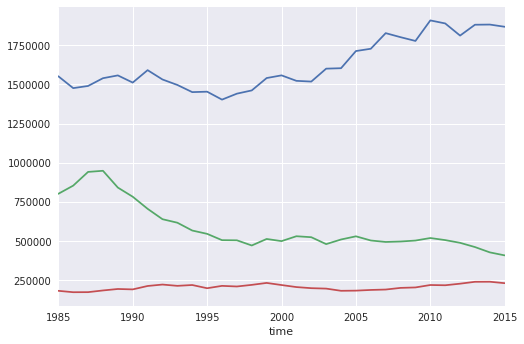

In [48]:
df_eu_yr = pd.read_pickle('Eurasian_basin_yearly')
df_am_yr = pd.read_pickle('Amerasian_basin_yearly')
df_sl_yr = pd.read_pickle('Slope_basin_yearly')

plt.style.use('seaborn')
#

df_am_yr["SAPE"].plot()
df_eu_yr["SAPE"].plot()
df_sl_yr["SAPE"].plot()
#plt.ylim(50000,780000)